# Cleaning of Data

@roman 

14 Oct, 2024

The code aims to clean the data by removing or imputing  values from the datase using common sense. The dataset is a time series data of the appraised value of properties in the country of Mexico.

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf
from itertools import product
from scipy import stats
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)

---
# Data

In [3]:
# read parquet
df_properties = pd.read_parquet("../../data/raw/appraisals.parquet")

# make columns lower case and blank spaces to _
df_properties.columns = df_properties.columns.str.lower().str.replace(' ', '_')

# see cols
print(df_properties.shape)
df_properties.head()

(2339244, 60)


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,property_account_id,special_common_installations_description,special_private_installations_description,complementary_common_works_description,age_in_months,parking_lots,valuation_date,common_areas_completion_percentage,private_works_completion_percentage,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,accessory_area,built_area,saleable_area,land_area,distance_to_public_transportation,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id
0,1,2,4,VISTA HERMOSA HUITEPEC,NO APLICA,29263,<NA>,<NA>,<NA>,<NA>,36,1,2022-06-14,NaN,100.0,NaN,NaN,NaN,NaN,4,4,301ef216-0137-4989-bdd0-32bf1adf1e9b,0.0,7,1,NaN,1,2,78,6f8c15c7-2914-40bb-87ff-59076af288c9,3,NaN,NaN,NaN,2,NaN,35a7806a-f686-4159-be91-16997e86d271,87aa63b6-9005-4ed3-ba44-fcd75453a9e9,16.737283,-92.672659,3,3,S/D,3,10.750000,216.809998,227.559998,302.700012,NaN,1.0,NaN,<NA>,3716737.0,3717000.0,2532281.13,1033417.8,<NA>,67,02086af7-ffbb-4e67-b857-27e6cef09b0d,2b225ce9-7742-512e-aac5-846811f1a6a1
1,1,2,4,MAYA,NO APLICA,97134,<NA>,<NA>,<NA>,<NA>,204,1,2022-11-15,NaN,100.0,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,50,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,13.380000,141.550003,154.929993,198.000000,NaN,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.0,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52
2,0,1,3,KANASIN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,60,1,2022-06-22,NaN,100.0,NaN,NaN,NaN,NaN,3,5,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,2,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,a7f6ef17-0933-4138-9aa9-99529929184d,20.928954,-89.546637,3,1,S/D,2,1.120000,44.349998,45.470001,144.800003,NaN,1.0,NaN,<NA>,446378.0,450000.0,279611.30,102663.2,<NA>,55,e57ad294-8db8-4ca1-b01f-7ccbc5981922,552216f4-540b-500d-a4e7-6be55b2b6703
3,0,1,3,MULCHECHEN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,192,1,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,2.160000,52.049999,54.209999,133.750000,NaN,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.0,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54
4,0,3,4,POBLACION MOTUL,NO APLICA,97430,<NA>,<NA>,<NA>,<NA>,116,0,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,4,4,1f637d21-f0cb-43be-b989-5923e4c01d94,0.0,31,1,NaN,1,2,52,bc0e00ba-8c35-465f-bbcd-61cedf83d6d8,1,NaN,NaN,NaN,2,NaN,90a0a9f7-fab3-4170-b3da-db49e122e41b,f6e764a4-141c-4b02-b902-4a158ec58c58,21.096391,-89.285366,3,2,S/D,2,19.049999,229.929993,248.979996,844.520020,NaN,1.0,NaN,<NA>,2779000.0,2779000.0,1767043.79,641835.2,<NA>,39,74af41d9-b7b3-464d-9302-7fd1f231ee26,5b18adfe-606c-590f-bc76-d3eabfd0ba41


In [4]:
# see columns
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339244 entries, 0 to 2339243
Data columns (total 60 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   half_bathrooms                             uint8         
 1   full_bathrooms                             uint8         
 2   property_class_more_common_in_area         string        
 3   neighborhood                               string        
 4   constructor                                string        
 5   zip_code                                   uint32        
 6   property_account_id                        string        
 7   special_common_installations_description   string        
 8   special_private_installations_description  string        
 9   complementary_common_works_description     string        
 10  age_in_months                              uint8         
 11  parking_lots                               uint8         
 12  

In [5]:
# get original columns
original_cols = df_properties.columns.copy()

---
# Univariate Cleaning

## Remove Data

- The object of study are property_type_id which are 2-4, which are houses, houses in condo and apartments. 
- The property_class_id should be on 1-7.  
- The land_area , built_area , saleable_area   should be greater than 0. 
- The saleable_area   should be greater than 30m2. 
- The built_price , market_price  and land_price_per_sqm should be greater than 0.   

In [6]:
# get values
valid_values = pd.Series(
    df_properties
    .agg(
        property_type_id = ('property_type_id', lambda x: x.between(2, 4).mean()),
        property_class_id = ('property_class_id', lambda x: x.between(1, 7).mean()),
        land_area = ('land_area', lambda x: (x > 0).mean()),
        built_area = ('built_area', lambda x: (x > 0).mean()),
        saleable_area = ('saleable_area', lambda x: (x > 30).mean()),
        built_price = ('built_price', lambda x: (x > 0).mean()),
        market_price = ('market_price', lambda x: (x > 0).mean()),
        land_price = ('land_price', lambda x: (x > 0).mean()),
        price = ('price', lambda x: (x > 0).mean()),
        bedrooms = ('bedrooms', lambda x: (x > 0).mean()),
        full_bathrooms = ('full_bathrooms', lambda x: (x > 0).mean()),
        remaining_useful_life = ('remaining_useful_life', lambda x: (x >= 0).mean()),
    )
    # get diagonal and only stay with the diagonal
    .values.diagonal()
)

# set index
valid_values.index = [
    'property_type_id',
    'property_class_id',
    'land_area',
    'built_area',
    'saleable_area',
    'built_price',
    'market_price',
    'land_price',
    'price',
    'bedrooms',
    'full_bathrooms',
    'remaining_useful_life'
]

# see
valid_values.to_frame().style.format("{:.4%}")

,0
property_type_id,98.2488%
property_class_id,100.0000%
land_area,100.0000%
built_area,100.0000%
saleable_area,99.9948%
built_price,98.9961%
market_price,99.9988%
land_price,100.0000%
price,100.0000%
bedrooms,100.0000%


In [7]:
# see how many rows are valid
mask = (
    (df_properties['property_type_id'].between(2, 4)) &
    (df_properties['property_class_id'].between(1, 7)) &
    (df_properties['land_area'] > 0) &
    (df_properties['built_area'] > 0) &
    (df_properties['saleable_area'] > 30) &
    (df_properties['built_price'] > 0) &
    (df_properties['market_price'] > 0) &
    (df_properties['bedrooms'] > 0) & 
    (df_properties['full_bathrooms'] > 0) & 
    (df_properties['price'] > 0) &
    (df_properties['land_price'] > 0) &
    (df_properties['remaining_useful_life'] >= 0)
)

# see
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}. Rows Removed: {df_properties.shape[0] - mask.sum()}")

Rows: 2275093. Percentage Removed: 2.74%. Rows Removed: 64151


In [8]:
# subset
df_properties = df_properties.loc[mask].reset_index(drop=True)

## Change of Values


In [9]:
# see remaining_useful_life negative
mask = df_properties['remaining_useful_life'] < 0
df_properties[mask]

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,property_account_id,special_common_installations_description,special_private_installations_description,complementary_common_works_description,age_in_months,parking_lots,valuation_date,common_areas_completion_percentage,private_works_completion_percentage,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,accessory_area,built_area,saleable_area,land_area,distance_to_public_transportation,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id


In [10]:
# multiply by -1
mask = df_properties['remaining_useful_life'].ge(0)

# see
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}. Rows Removed: {df_properties.shape[0] - mask.sum()}")

Rows: 2275093. Percentage Removed: 0.00%. Rows Removed: 0


In [11]:
# subset
df_properties = df_properties.loc[mask].reset_index(drop=True)

---
# Multivariate Cleaning

The following relationship should hold: 
- x['built_area'] + x['superficie_accesoria'] >= x['saleable_area']
- The valor_concluido & market_price should be near
- The valor_concluido &  saleable_area should be near

## Surfaces

The selling surface should be at most the sum of the built surface and the accessory surface.

In [12]:
# see case where built surface is the same as surface sold group by property_type_id
df_properties = (
    df_properties
    .assign(
        surface_construida_accesoria=lambda x: (
            x['built_area'] + x['accessory_area']
            )
    )
)

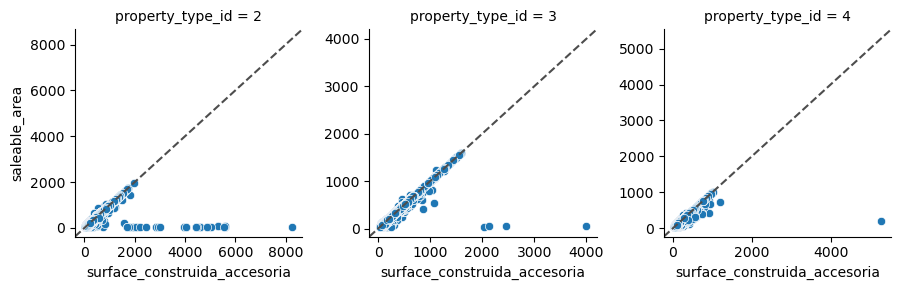

In [13]:
# see relationship between saleable_area and same_surface_construida_accesoria
g = sns.FacetGrid(
    df_properties,
    col='property_type_id',
    col_wrap=5,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'surface_construida_accesoria',
    'saleable_area',
    )

# set same limits for each plot
for ax in g.axes:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_xlim())

# add identity line
for ax in g.axes:
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

In [14]:
# props that surface_construida_accesoria >= saleable_area
mask = df_properties['surface_construida_accesoria'] >= df_properties['saleable_area']
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}, Rows Removed: {df_properties.shape[0] - mask.sum()}")

Rows: 2218336. Percentage Removed: 2.49%, Rows Removed: 56757


In [15]:
# will not subset
df_properties.shape

(2275093, 61)

## Pricing
The valor_concluido & market_price should be near

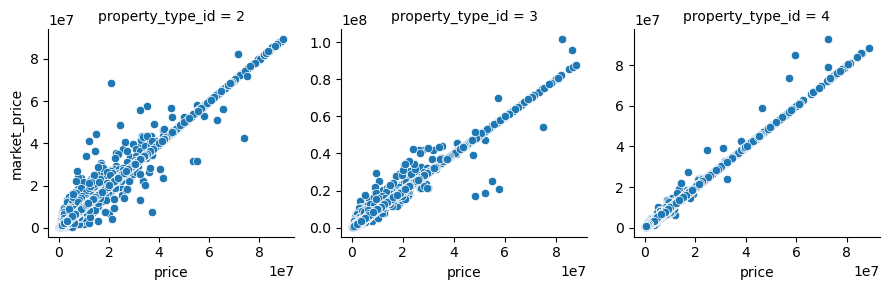

In [16]:
# see relationship between price and market_price
g = sns.FacetGrid(
    df_properties,
    col='property_type_id',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'price',
    'market_price',
    )


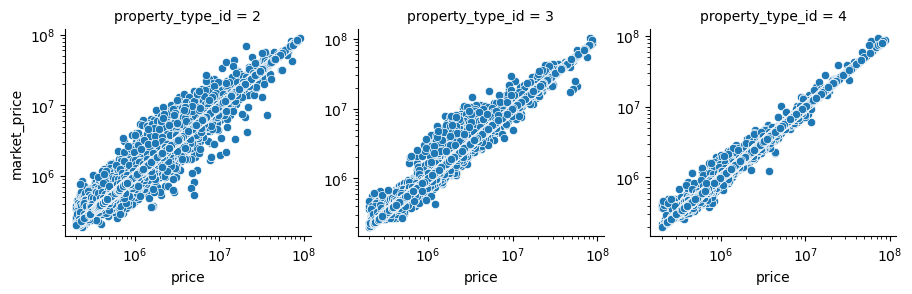

In [17]:
# see relationship between price and market_price
g = sns.FacetGrid(
    df_properties,
    col='property_type_id',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'price',
    'market_price',
    )

# log scale
g.set(yscale='log', xscale='log')

Rows: 2259316. Percentage Removed: 0.69%, Rows Removed: 15777


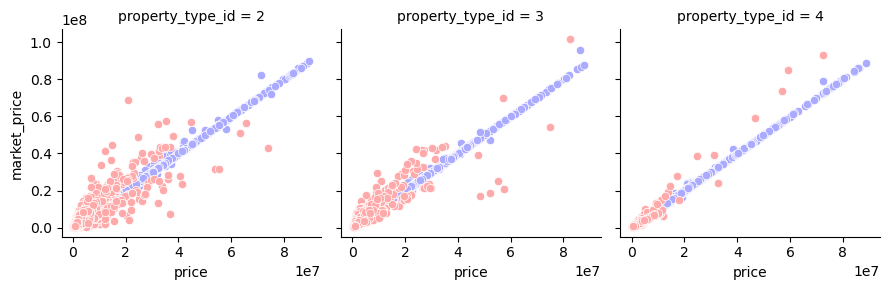

In [18]:
# flag properties which market_price is 10% greater than price
mask = (
    df_properties['price'].le(df_properties['market_price'] * 1.15) &
    df_properties['price'].ge(df_properties['market_price'] * 0.85)
    )

# flag
df_properties['pricing_outlier'] = 1
df_properties.loc[mask, 'pricing_outlier'] = 0

# plot
print(f"Rows: {mask.sum()}. Percentage Removed: {1 - mask.mean():.2%}, Rows Removed: {df_properties.shape[0] - mask.sum()}")
g = sns.FacetGrid(
    df_properties,
    col='property_type_id',
    col_wrap=3,
    hue='pricing_outlier',
    palette='bwr',
    )

# plot
g.map(
    sns.scatterplot,
    'price',
    'market_price',
    alpha=1
    )


In [19]:
# subset
df_properties = df_properties[mask].reset_index(drop=True)

# drop columns
df_properties = df_properties.drop(columns=[
    'surface_construida_accesoria',
    'pricing_outlier'
])

## Price per sqm

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='price_per_sqm', ylabel='Density'>

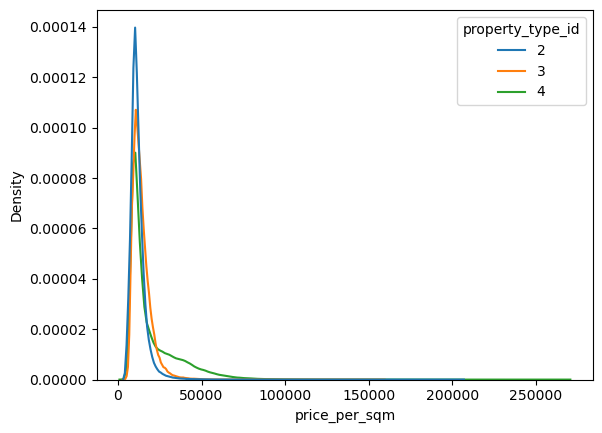

In [20]:
# manually create price per m2
df_properties['price_per_sqm'] = df_properties['price'] / df_properties['saleable_area']

# see distribution
sns.kdeplot(
    data=df_properties,
    x='price_per_sqm',
    hue='property_type_id',
    common_norm=False,
    palette='tab10',
    )

In [21]:
# see distribution
df_properties.groupby('property_type_id')['price_per_sqm'].describe()

,count,mean,std,min,25%,50%,75%,max
property_type_id,,,,,,,,
2,1134324.0,11973.214608,4837.184600,4000.000000,9200.602895,11036.372863,13578.324756,206008.551771
3,590101.0,14136.122093,5718.980091,4036.585366,10356.104479,12845.621668,16459.063169,158300.810084
4,534891.0,19864.835240,15039.610444,4133.451562,9988.722459,13335.866416,25052.309248,267325.273984


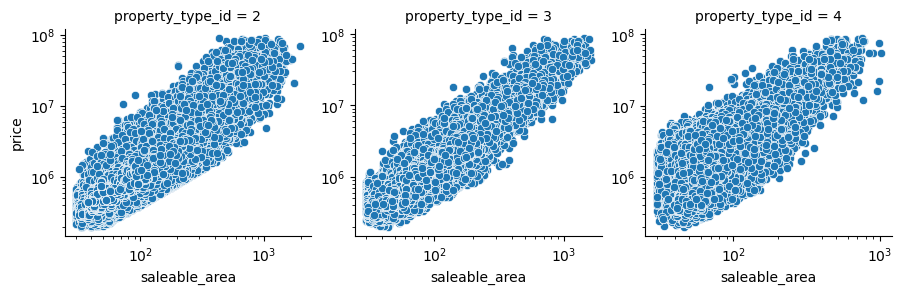

In [22]:
# see relationship between market_price and saleable_area
g = sns.FacetGrid(
    df_properties,
    col='property_type_id',
    col_wrap=3,
    sharex=False,
    sharey=False,
    )

# plot
g.map(
    sns.scatterplot,
    'saleable_area',
    'price',
    )

# log scale
g.set(yscale='log', xscale='log')

In [23]:
# don't subset
df_properties.shape

(2259316, 61)

---
# Save

In [24]:
# subset columns to original
df_properties[original_cols].head()

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,property_account_id,special_common_installations_description,special_private_installations_description,complementary_common_works_description,age_in_months,parking_lots,valuation_date,common_areas_completion_percentage,private_works_completion_percentage,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,accessory_area,built_area,saleable_area,land_area,distance_to_public_transportation,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id
0,1,2,4,VISTA HERMOSA HUITEPEC,NO APLICA,29263,<NA>,<NA>,<NA>,<NA>,36,1,2022-06-14,NaN,100.0,NaN,NaN,NaN,NaN,4,4,301ef216-0137-4989-bdd0-32bf1adf1e9b,0.0,7,1,NaN,1,2,78,6f8c15c7-2914-40bb-87ff-59076af288c9,3,NaN,NaN,NaN,2,NaN,35a7806a-f686-4159-be91-16997e86d271,87aa63b6-9005-4ed3-ba44-fcd75453a9e9,16.737283,-92.672659,3,3,S/D,3,10.750000,216.809998,227.559998,302.700012,NaN,1.0,NaN,<NA>,3716737.0,3717000.0,2532281.13,1033417.8,<NA>,67,02086af7-ffbb-4e67-b857-27e6cef09b0d,2b225ce9-7742-512e-aac5-846811f1a6a1
1,1,2,4,MAYA,NO APLICA,97134,<NA>,<NA>,<NA>,<NA>,204,1,2022-11-15,NaN,100.0,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,50,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,13.380000,141.550003,154.929993,198.000000,NaN,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.0,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52
2,0,1,3,KANASIN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,60,1,2022-06-22,NaN,100.0,NaN,NaN,NaN,NaN,3,5,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,2,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,a7f6ef17-0933-4138-9aa9-99529929184d,20.928954,-89.546637,3,1,S/D,2,1.120000,44.349998,45.470001,144.800003,NaN,1.0,NaN,<NA>,446378.0,450000.0,279611.30,102663.2,<NA>,55,e57ad294-8db8-4ca1-b01f-7ccbc5981922,552216f4-540b-500d-a4e7-6be55b2b6703
3,0,1,3,MULCHECHEN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,192,1,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,2.160000,52.049999,54.209999,133.750000,NaN,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.0,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54
4,0,3,4,POBLACION MOTUL,NO APLICA,97430,<NA>,<NA>,<NA>,<NA>,116,0,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,4,4,1f637d21-f0cb-43be-b989-5923e4c01d94,0.0,31,1,NaN,1,2,52,bc0e00ba-8c35-465f-bbcd-61cedf83d6d8,1,NaN,NaN,NaN,2,NaN,90a0a9f7-fab3-4170-b3da-db49e122e41b,f6e764a4-141c-4b02-b902-4a158ec58c58,21.096391,-89.285366,3,2,S/D,2,19.049999,229.929993,248.979996,844.520020,NaN,1.0,NaN,<NA>,2779000.0,2779000.0,1767043.79,641835.2,<NA>,39,74af41d9-b7b3-464d-9302-7fd1f231ee26,5b18adfe-606c-590f-bc76-d3eabfd0ba41


In [25]:
# drop columns property_account_id, distance_to_public_transportation, special_private_installations_description, special_common_installations_description, common_areas_completion_percentage, complementary_common_works_description, private_works_completion_percentage
cols2drop = [
    'property_account_id',
    'distance_to_public_transportation',
    'special_private_installations_description',
    'special_common_installations_description',
    'common_areas_completion_percentage',
    'complementary_common_works_description',
    'private_works_completion_percentage',
    'accessory_area'
]

# drop columns
original_cols = [x for x in original_cols if x not in cols2drop]

# see columns
print(len(original_cols))
original_cols

52


['half_bathrooms',
 'full_bathrooms',
 'property_class_more_common_in_area',
 'neighborhood',
 'constructor',
 'zip_code',
 'age_in_months',
 'parking_lots',
 'valuation_date',
 'potable_water_service_id',
 'lighting_service_id',
 'sidewalk_id',
 'project_quality_id',
 'property_class_id',
 'conservation_status_id',
 'controller_id',
 'elevator_service_id',
 'state_id',
 'equipment_id',
 'curb_id',
 'infrastructure_service_id',
 'road_materials_id',
 'municipality_id',
 'grantor_id',
 'urban_proximity_id',
 'water_collection_service_id',
 'electrical_supply_service_id',
 'telephone_service_supply_id',
 'property_type_id',
 'public_transportation_service_id',
 'valuation_unit_id',
 'valuation_professional_id',
 'latitude',
 'longitude',
 'level',
 'total_levels',
 'purpose_of_appraisal',
 'bedrooms',
 'built_area',
 'saleable_area',
 'land_area',
 'rentable_units',
 'rentable_units_subject_property',
 'current_use',
 'market_price',
 'price',
 'built_price',
 'land_price',
 'access_rout

In [26]:
# save
os.makedirs("../../data/interim", exist_ok=True)
df_properties[original_cols].to_parquet("../../data/interim/cleaned_data_s1.parquet")

---
# Sandbox

count    2.259316e+06
mean     5.231365e+01
std      7.304519e+01
min      0.000000e+00
25%      0.000000e+00
50%      8.000000e+00
75%      9.600000e+01
max      2.550000e+02
Name: age_in_months, dtype: float64


<Axes: >

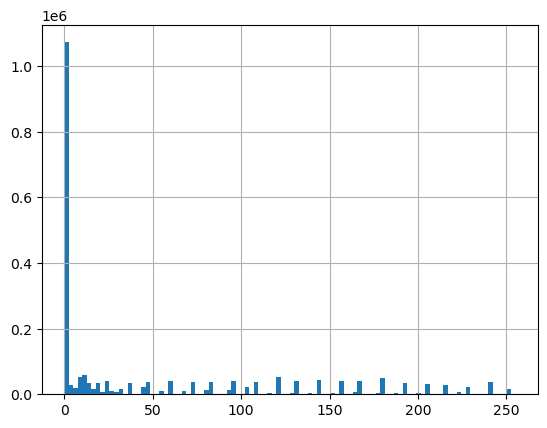

In [27]:
# see age_in_months
print(df_properties['age_in_months'].describe())
df_properties['age_in_months'].hist(bins=100)